# Implementación de *Simulated Annealing* para el problema del agente viajero

**Importar las librerías necesarias para poder trabajar con los datos**

In [1]:
import pandas as pd
import numpy as np
from numpyencoder import NumpyEncoder
import matplotlib.pyplot as plt
import json

**Leer los datos (la matriz de distancias) y crear un DataFrame a partir de ellos**

In [2]:
CITIES = np.empty((128, 3))

with open('files/coordinates.txt', 'r') as f:
    for index, line in enumerate(f.readlines()):
        line = line.strip().split()
        CITIES[index] = [index, float(line[0]), float(line[1])]

DATA = pd.read_csv('files/cities.csv', header=None)

# Vamos a imprimir los primeros 5 para asegurarnos de que todo está bien
DATA.head(5)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0,966,1513,2964,1149,927,1611,1510,390,466,...,1018,168,565,1700,1636,2019,1458,1564,2871,348
1,966,0,2410,1520,1817,729,686,290,1823,168,...,548,1127,432,2265,558,571,943,198,1917,2541
2,1513,2410,0,604,481,2742,1833,826,214,1618,...,752,486,590,2132,1095,2154,1211,2217,2673,1570
3,2964,1520,604,0,595,1289,1446,466,1139,430,...,1861,861,499,1408,986,2719,1437,769,1038,2343
4,1149,1817,481,595,0,494,550,2641,765,934,...,216,1994,324,2187,260,2586,1974,2352,2243,691


**Hacer un primer camino aleatorio**

In [3]:
PATH = np.random.permutation(CITIES)

**Definir la función del costo del camino actual**

In [4]:
def cost(path: np.array) -> float:
    """Calcula el costo de la ruta elegida al momento

    Args:
        path (np.array): Array que contiene la ruta que se debe de seguir al momento

    Returns:
        float: El costo de la ruta
    """
    global DATA
    
    cost = 0
    
    # Calcular el costo del camino
    for i in range(len(path) - 1):
        cost += DATA.iloc[int(path[i, 0]), int(path[i + 1, 0])]
        
    # Sumar el costo de volver al principio
    cost += DATA.iloc[int(path[-1, 0]), int(path[0, 0])]
    return cost

**Definir la función de obtener un nuevo camino 'vecino' del actual**

In [5]:
def generate_path(path: np.array) -> np.array:
    """Genera una ruta tomando dos elementos aleatorios de la ruta, y haciendo un 'reverse' de todos los elementos 
        dentro del array formado por estas dos ciudades como extremos

    Args:
        path (np.array): La ruta actual

    Returns:
        np.array: La nueva ruta
    """
    # Tomar dos elementos aleatorios
    i, j = np.random.choice([i for i in range(0, 128)], size=2, replace=False)
    
    # Hacer el swap
    new_path = np.copy(path)
    new_path[i : j] = path[i : j][::-1]
    
    return new_path

## Función que usa todas las funciones anteriores para generar la mejor ruta

In [6]:

def simulated_annealing(path: np.array, t: float, l: int, max_loops: int = 2000000, t_update: float = 0.999, save_graph_values: bool = True, global_min: float = None, seed: int = 0) -> list:
    """Función que implementa el algoritmo de Simulated Annealing

    Args:
        path (np.array): La ruta actual
        t (float): Temperatura
        l (int): Cada cuantas iteraciones se debe de actualizar la temperatura
        max_loops (int, optional): Cantidad máxima de iteraciones. Defaults to 1000000.
        t_update (float, optional): Factor de actualización de la temperatura. Defaults to 0.99.
        save_graph_values (bool, optional): Si se debe de guardar los valores de la función de costo para graficar. Defaults to True.
        global_min (float, optional): Valor mínimo global. Defaults to None.
        seed (int, optional): Semilla para el random. Defaults to 0.

    Returns:
        np.array: La nueva ruta
    """
    np.random.seed(seed)
    
    first_t = t
    diff = 0
    k = 0
    cost_path = cost(path)
    super_min_cost = cost_path
    results = []
    t_values = []
    information = {
        'T': t,
        'L': l,
        't_update': t_update,
        'max_loops': max_loops,
        'paths': [
            path
        ]
    }

    while k < max_loops:
        # Generar una nueva ruta
        new_path = generate_path(path)

        # Calcular la diferencia de costos
        cost_new_path = cost(new_path)
        diff = cost_new_path - cost_path
        
        # Calcular el minimo costo que se ha tenido en todas las corridas y si es menor que el actual actualizar la información
        if cost_new_path < super_min_cost:
            super_min_cost = cost_new_path
            information['paths'].append(new_path)

        # Si la diferencia es menor que 0, entonces la nueva ruta es mejor, por lo que la actual se debe de actualizar
        if diff < 0:
            path = new_path
            cost_path = cost_new_path

        # Si la diferencia es mayor que 0, entonces la nueva ruta es peor, por lo que se debe de probar si debe de ser aceptada
        elif np.random.rand() < np.exp(-diff / t):
            path = new_path
            cost_path = cost_new_path

        # Escribir el costo dentro del array de resultados y T para graficar
        results.append(cost_path)
        t_values.append(t)

        # Aumentar K y cada L pasos disminuir T
        k += 1
        if k % l == 0:
            t *= t_update
            
            
    # Guardar la información dentro de un archivo
    if save_graph_values and super_min_cost < global_min:
        with open(f'files/SA_t={first_t}_l={l}_tupdate={t_update}_seed={seed}_maxloops={max_loops}_result={results[-1]}_minimum={super_min_cost}.json', 'w') as file:
            json.dump(information, file, indent=0, sort_keys=True,separators=(',', ':'), ensure_ascii=False, cls=NumpyEncoder)
    
    return results, t_values, super_min_cost
    
    

**Ejecutar el programa**

En la siguiente celda es donde vamos a ejecutar todo el programa. El programa se ejecutó durante toda una noche para poder encontrar la mejor solución posible. Para poder correr el programa se tiene que dejar la variable ```execute=True```.

**NO CORRAS ESTA CELDA PARA VISUALIZAR EL CÓDIGO**
- Es un loop infinito
- Tarda aprox. 7min por iteración
- Se puede visualizar el notebook sin correr la celda con los valores ya guardados

**SOLO CORRELA SI LO QUE QUIERES ES HACER TU MISMO LA SIMULACIÓN**

In [7]:
execute = False
save_graph = True
graph_t = False
save_graph_values = False
global_min = cost(PATH)
counter = 0


if execute:
    while True:
        counter += 1
        
        t = np.random.normal(loc=2500.0, scale=500, size=1)[0]
        l = np.random.normal(loc=100.0, scale=20,size=1)[0]
        t_update = np.random.normal(loc=0.997, scale=0.001,size=1)[0]
        max_loops = 200000
        seed = np.random.randint(0, 1000000000)
    
        # run algorithm
        results, t_values, min_cost = simulated_annealing(path=PATH, t=t, l=int(l), max_loops=max_loops, t_update=t_update, save_graph_values=save_graph_values, global_min=global_min, seed=seed)
    
        # graph results
        if save_graph and min_cost < global_min:
            global_min = min_cost
            
            plt.figure(figsize=(8,6), facecolor='w')
            plt.plot(range(len(results)), results)
            plt.title(f'Cost of Simulated Annealing. min={min_cost}')
            plt.xlabel('k iterations')
            plt.ylabel('Cost')
    
            # save plot on disk
            plt.savefig(f'./plots/SA_t={t}_l={int(l)}_tupdate={t_update}_seed={seed}_maxloops={max_loops}_result={results[-1]}_minimum={min_cost}.png')
            plt.clf()
            
            # print results on screen
            print(f"{counter}. cost: {min_cost}")
    
        ########################
        if graph_t:
            # graph T values
            plt.figure(figsize=(8,6), facecolor='w')
            plt.plot(range(len(t_values)), t_values)
            plt.title(f'Value of T')
            plt.xlabel('k iterations')
            plt.ylabel('T')
    
            # save plot on disk
            plt.savefig(f'./plots/T_t={t}_l={int(l)}_tupdate={t_update}_seed={seed}_maxloops={max_loops}_result={results[-1]}_minimum={min_cost}.png')
            plt.clf()
        
        print(f"Finished with min_cost: {min_cost}")

Después de varias corridas, nos damos cuenta de que el mejor resultado es el siguiente: ```23,573``` km.

Este resultado se logró con los valores:  
-```T: 2551.2443971624784```  
-```L: 90```  
-```T update: 0.996675538831161```  
-```seed: 907328789```  
-```max loops: 200000```  

<img src="plots/SA_t=2551.2443971624784_l=90.84891589294462_tupdate=0.996675538831161_seed=907328789_maxloops=200000_result=23573_minimum=23573.png"/>

Además, podemos graficar cuál es el decremento de T conforme avanza el tiempo (conforme k va creciento). Lo podemos ver en la siguiente gráfica con la que se usaron los valores:
-```T: 3356.68371459288```  
-```L: 80```  
-```T update: 0.997864492793074```  
-```seed: 962658688```  
-```max loops: 200000```  

<img src="plots/T_t=3356.68371459288_l=80.7446550799253_tupdate=0.997864492793074_seed=962658688_maxloops=200000_result=25432_minimum=25432.png"/>




## Animación

**Primero vamos a graficar todas las coordenadas**

In [8]:
COORDS = np.empty((128, 2))

with open('files/coordinates.txt', 'r') as f:
    for index, line in enumerate(f.readlines()):
        line = line.strip().split()
        COORDS[index] = [float(line[0]), float(line[1])]

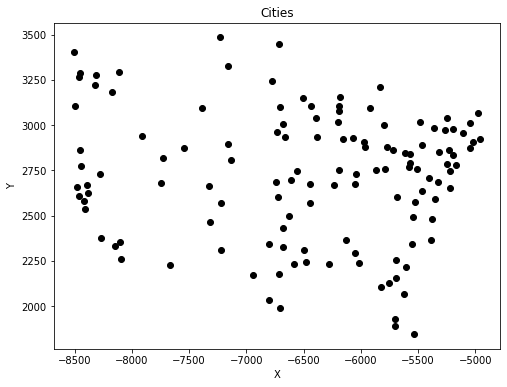

In [9]:
plt.figure(figsize=(8,6), facecolor='w')

plt.plot(COORDS.T[0], COORDS.T[1], 'o', c='black')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cities")

plt.savefig(f'./map.png')
plt.show()

**Ahora vamos a graficar tanto el primer camino que se eligió como el último.**

1. Cargamos la información del archivo donde guardamos todos los caminos elegidos
2. Dibujamos el primer path
3. Dibujamos el último path

In [11]:
# Declarar la variable que va a guardar toda la información
information = {}

# Leer el archivo que resultó con toda la información de la corrida
with open('./files/SA_t=2551.2443971624784_l=90_tupdate=0.996675538831161_seed=907328789_maxloops=200000_result=23573_minimum=23573.json', 'r') as file:
    information = json.load(file)

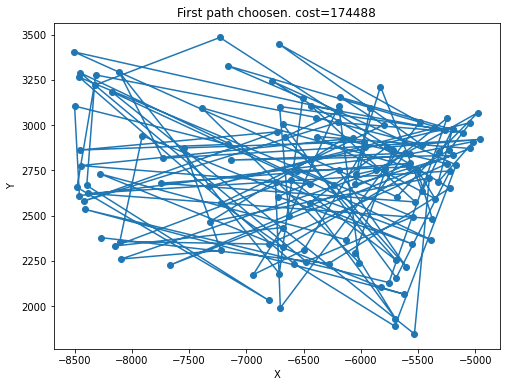

<Figure size 432x288 with 0 Axes>

In [21]:
save_plot_on_disk = False
paths = np.array(information['paths'])

plt.figure(figsize=(8,6), facecolor='w')
plt.plot(paths[0, :, 1], paths[0, :, 2], '-o')
plt.title(f'First path choosen. cost={cost(paths[0, :, :])}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

if save_plot_on_disk:
# save plot on disk
    plt.savefig(f'./plots/first_path.png')
    
plt.clf()

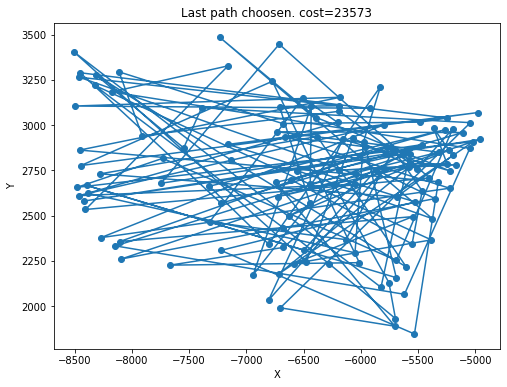

<Figure size 432x288 with 0 Axes>

In [23]:
save_plot_on_disk = True

plt.figure(figsize=(8,6), facecolor='w')
plt.plot(paths[-1, :, 1], paths[-1, :, 2], '-o')
plt.title(f'Last path choosen. cost={cost(paths[-1, :, :])}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

if save_plot_on_disk:
# save plot on disk
    plt.savefig(f'./plots/last_path.png')
    
plt.clf()

**Ahora vamos a crear todos los plots y guardarlos como imagenes para poderlas juntar después como una visualización de animación**

```

    
paths = np.array(information['paths'])
for i in range(len(paths)):
    plt.figure(figsize=(8,6), facecolor='w')
    plt.plot(paths[i, :, 1], paths[i, :, 2], '-o')
    plt.title(f'step: {i}.  Cost: {cost(paths[i, :, :])}')
    plt.xlabel('X')
    plt.ylabel('Y')

    # save plot on disk
    # plt.savefig(f'./plots/animation/{i}.png')
    # plt.show()
    # plt.clf()